In [ ]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns
import collections


data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


In [4]:
# ------------------------------------------------------------------
# Required libraries
# ------------------------------------------------------------------
import polars as pl
import numpy as np
import torch

# ------------------------------------------------------------------
# 1. Load data into a Polars DataFrame
# ------------------------------------------------------------------
# df = pl.read_csv("file.csv")          # Uncomment if reading from file
df = pl.from_pandas(data)               # Convert from pandas if already in memory

# ------------------------------------------------------------------
# 2. Collect year columns and build the observation matrix [N, T]
# ------------------------------------------------------------------
year_cols = sorted([c for c in df.columns if c.startswith("y_")])
T = len(year_cols)

obs = (
    df.select(year_cols)                # Select y_* columns
      .fill_null(0)                     # Replace NaNs by 0
      .to_numpy()
      .astype(int)                      # Ensure integer type
)

# ------------------------------------------------------------------
# 3. Create fixed covariates per individual
# ------------------------------------------------------------------
df = df.with_columns(
    [
        (pl.col("gender") == "F").cast(pl.Int8).alias("gender_code"),      # 0 = M, 1 = F
        (
            (pl.col("birth_year") - pl.col("birth_year").mean()) /
            pl.col("birth_year").std()
        ).alias("birth_year_norm")                                         # Standardised birth year
    ]
)

birth_year_norm = df["birth_year_norm"].to_numpy()    # Shape [N]
gender_code     = df["gender_code"].to_numpy()        # Shape [N]

# ------------------------------------------------------------------
# 4. Build dynamic covariates (age and COVID dummy)
# ------------------------------------------------------------------
years_num = np.array([int(c[2:]) for c in year_cols])                 # e.g. [2009, …, 2023]
ages      = years_num[None, :] - df["birth_year"].to_numpy()[:, None] # Shape [N, T]
ages_norm = (ages - ages.mean()) / ages.std()                         # Standardised age

covid_years = np.isin(years_num, [2020, 2021, 2022]).astype(float)    # Shape [T]
covid_years = np.tile(covid_years, (df.height, 1))                    # Shape [N, T]

# ------------------------------------------------------------------
# 5. Assemble the full covariate tensor [N, T, 5]
#    Order: birth_year_norm, gender_code, ages_norm, covid_years, const
# ------------------------------------------------------------------
base_cov  = np.stack([birth_year_norm, gender_code], axis=1)          # Shape [N, 2]
base_cov  = np.repeat(base_cov[:, None, :], T, axis=1)                # [N, T, 2]

dyn_cov   = np.stack([ages_norm, covid_years], axis=2)                # [N, T, 2]

const_cov = np.ones((df.height, T, 1), dtype=np.float32)              # Constant term

full_cov  = np.concatenate([base_cov, dyn_cov, const_cov], axis=2)    # [N, T, 5]
cov_names = ["birth_year_norm",
             "gender_code",
             "ages_norm",
             "covid_years",
             "const"]

# ------------------------------------------------------------------
# 6. Convert to PyTorch tensors (optional)
# ------------------------------------------------------------------
obs_torch      = torch.tensor(obs,      dtype=torch.long)
full_cov_torch = torch.tensor(full_cov, dtype=torch.float)

# ------------------------------------------------------------------
# 7. Quick sanity check
# ------------------------------------------------------------------
print("obs       :", obs.shape)        # (N, T)
print("covariates:", full_cov.shape)   # (N, T, 5)
print("order     :", cov_names)        # Confirm column order

obs       : (9236, 15)
covariates: (9236, 15, 5)
order     : ['birth_year_norm', 'gender_code', 'ages_norm', 'covid_years', 'const']


In [1]:
# %% [markdown] ------------------------------------------------------------
# Loop over K = 2..6  – ELBO + held-out log-likelihood (5-fold CV)
# -------------------------------------------------------------------------
import pyro, torch, numpy as np, pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import ClippedAdam
from sklearn.model_selection import KFold

# ------------------------------------------------------------
#  helper: safe positive parameter
# ------------------------------------------------------------
def positive_param(name, shape, init_val=2.0):
    """
    Creates / fetches a positive param and clamps it in-place
    to avoid 0 or inf.  Shape depends on K, so we pass a lambda
    initialiser to Pyro.
    """
    p = pyro.param(
        name,
        lambda: torch.full(shape, init_val),
        constraint=dist.constraints.positive,
    )
    with torch.no_grad():
        p.data.clamp_(min=1e-3, max=1e3)
    return p

# ------------------------------------------------------------
def make_model(K):
    def model(obs):
        N, T = obs.shape
        
        pi  = pyro.sample("pi",  dist.Dirichlet(torch.ones(K)))
        with pyro.plate("row", K):
            A = pyro.sample("A", dist.Dirichlet(torch.ones(K)))
        lam = pyro.sample("lam",
                          dist.Gamma(2.*torch.ones(K),
                                     1.*torch.ones(K)).to_event(1))

        with pyro.plate("donor", N):
            z = pyro.sample("z0", dist.Categorical(pi),
                            infer={"enumerate": "parallel"})
            for t in pyro.markov(range(T)):
                pyro.sample(f"y_{t}", dist.Poisson(lam[z]), obs=obs[:, t])
                if t < T-1:
                    z = pyro.sample(f"z_{t+1}", dist.Categorical(A[z]),
                                    infer={"enumerate": "parallel"})
    return model

# ------------------------------------------------------------
def make_guide(K):
    def guide(obs):
        positive_param("pi_alpha", (K,),  2.0)
        positive_param("A_alpha",  (K,K), 1.0)
        positive_param("r_alpha",  (K,),  2.0)
        positive_param("r_beta",   (K,),  1.0)

        pyro.sample("pi",  dist.Dirichlet(pyro.param("pi_alpha")))
        with pyro.plate("row", K):
            pyro.sample("A", dist.Dirichlet(pyro.param("A_alpha")))
        pyro.sample("lam", dist.Gamma(pyro.param("r_alpha"),
                                      pyro.param("r_beta")).to_event(1))
    return guide



In [10]:
# ------------------------------------------------------------
def fit_hmm(K, data, n_steps=1200, lr=0.01, seed=0, verbose=True):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()

    svi = SVI(
        make_model(K),
        make_guide(K),
        ClippedAdam({"lr": lr, "clip_norm": 10.0}),
        TraceEnum_ELBO(max_plate_nesting=1),
    )

    for s in range(n_steps):
        loss = svi.step(data)
        if verbose:
            print(f"[{s}] Loss = {loss:.2f}")
    elbo = -svi.evaluate_loss(data)          # più alto è meglio
    return elbo, {k: v.detach().clone() for k, v in pyro.get_param_store().items()}

In [38]:
e , p = fit_hmm(3, obs_torch, n_steps=1000, lr=0.01, seed=0, verbose=False)

In [39]:
e, p

(-146450.03125,
 {'pi_alpha': tensor([3.8441, 0.9762, 0.8994]),
  'A_alpha': tensor([[4.7360, 0.6284, 0.4361],
          [0.2893, 7.9186, 0.5164],
          [0.2579, 0.3808, 9.8350]]),
  'r_alpha': tensor([0.3009, 1.8811, 1.6564]),
  'r_beta': tensor([10.1378,  1.0626,  1.2074])})

In [ ]:
lam = p["r_alpha"] / p["r_beta"]             # [K]

lam 


(tensor([0.0297, 1.7702, 1.3718]), 0.0296833382657591)

In [ ]:
# def train_suite(obs_data, num_states, num_inits=3, n_steps=1200, lr=0.01, verbose=True):
#     best_scores = collections.defaultdict(dict)
#     best_models = collections.defaultdict(dict)

#     for K in num_states:
#         for i in range(num_inits):
#             seed = i  # cambia inizializzazione
#             elbo, params = fit_hmm(K, obs_data, n_steps=n_steps, lr=lr, seed=seed)
#             if verbose:
#                 print(f"Training VI(K={K}, init={i}) ELBO = {elbo:.2f}")
            
#             if best_models["VI"].get(K) is None or best_scores["VI"][K] < elbo: # keep greatest ELBO
#                 best_models["VI"][K] = params
#                 best_scores["VI"][K] = elbo

#     return best_models, best_scores

# def print_best_models(best_models, best_scores):
#     for algo, scores in best_scores.items():
#         best_score = max(scores.values())
#         best_n, _ = max(scores.items(), key=lambda x: x[1])
#         print(f"\nBest models for algorithm '{algo}':")
#         for n, score in scores.items():
#             flag = " * <- Best Model" if score == best_score else ""
#             print(f"{algo}({n}): {score:.4f}{flag}")

#         print(f"\nBest model for {algo} with K={best_n}, ELBO={best_score:.4f}")
#         params = best_models[algo][best_n]
        
#         # Stampa i parametri principali appresi in modo leggibile
#         for k, v in params.items():
#             # Se è tensor, converto in numpy e stampo forma + primi valori
#             if hasattr(v, "numpy"):
#                 arr = v.numpy()
#                 print(f"Param '{k}': shape={arr.shape}, values (sample)={arr.flatten()[:5]}")
#             else:
#                 print(f"Param '{k}': {v}")

# def plot_scores(best_scores):
#     for algo, scores in best_scores.items():
#         Ks = sorted(scores.keys())
#         vals = [scores[K] for K in Ks]
#         plt.plot(Ks, vals, marker='o', label=algo)
#     plt.xlabel("Number of states K")
#     plt.ylabel("Best ELBO")
#     plt.title("Best ELBO per numero di stati e algoritmo")
#     plt.legend()
#     plt.grid(True)
#     plt.show()             

In [ ]:
def log_evidence(params, obs):
    """
    Calcola log p(obs) usando il forward algorithm
    con i parametri appresi (params). E' diverso da 
    EM nel quale i parametri sono aggiornati, qui i parametri sono fissi.
    """
    with torch.no_grad():
        K = params["pi_alpha"].numel()
        
        pi  = dist.Dirichlet(params["pi_alpha"]).mean          # [K]
        A   = dist.Dirichlet(params["A_alpha"]).mean           # [K,K]
        lam = params["r_alpha"] / params["r_beta"]             # [K]

        log_pi = pi.log()                          # log iniziale
        log_A  = (A / A.sum(1, keepdim=True)).log()             # log matrice transizione
        emis   = dist.Poisson(lam).log_prob(obs.unsqueeze(-1))  # (N,T,K) emission log-prob

        N, T = obs.shape
        log_alpha = log_pi + emis[:, 0]                          # inizializzazione

        for t in range(1, T):
            # forward update: logsumexp su dimensione degli stati precedenti
            log_alpha = (log_alpha.unsqueeze(2) + log_A).logsumexp(1) + emis[:, t]

        # log-likelihood sequenze (somma su sequenze)
        total_ll = log_alpha.logsumexp(1).sum().item()
        return total_ll

In [ ]:
def elbo_vs_evidence(obs_data, num_states, num_inits=3, n_steps=1200, lr=0.01, verbose=True):
    best_models = collections.defaultdict(dict)
    best_scores = {
        "log_p(X)": collections.defaultdict(float),
        "elbo":     collections.defaultdict(float),
    }

    for K in num_states:
        best_elbo = float("-inf")
        best_logp = float("-inf")
        best_elbo_params = None
        best_logp_params = None

        for i in range(num_inits):
            seed = i
            elbo, params = fit_hmm(K, obs_data, n_steps=n_steps, lr=lr, seed=seed, verbose=verbose)
            logp = log_evidence(params, obs_data)

            if verbose:
                print(f"Training VI(K={K}, init={i}) ELBO = {elbo:.2f}, log p(X) = {logp:.2f}")

            # Aggiorna miglior modello secondo log p(X)
            if logp > best_logp:
                best_logp = logp
                best_logp_params = params

            # Aggiorna miglior modello secondo ELBO
            if elbo > best_elbo:
                best_elbo = elbo
                best_elbo_params = params

        best_models["log_p(X)"][K] = best_logp_params
        best_models["elbo"][K]     = best_elbo_params
        best_scores["log_p(X)"][K] = best_logp
        best_scores["elbo"][K]     = best_elbo

    return best_models, best_scores

In [ ]:
best_models, best_scores = elbo_vs_evidence(obs_torch, range(2, 7), num_inits=5, verbose=True)

# Accesso al miglior modello per log p(X)
best_logp_model_K3 = best_models["log_p(X)"][3]

# Accesso al valore log p(X)
print("log p(X) migliore per K=3:", best_scores["log_p(X)"][3])

[0] Loss = 190806.86
[1] Loss = 166922.95
[2] Loss = 258748.02
[3] Loss = 316802.31
[4] Loss = 229128.73
[5] Loss = 223041.70
[6] Loss = 519905.19
[7] Loss = 182007.92
[8] Loss = 199604.70
[9] Loss = 188319.81
[10] Loss = 220637.42
[11] Loss = 187117.12
[12] Loss = 264994.47
[13] Loss = 193498.72
[14] Loss = 163885.45
[15] Loss = 188465.58
[16] Loss = 243957.48
[17] Loss = 205918.03
[18] Loss = 220569.45
[19] Loss = 209946.52
[20] Loss = 177216.30
[21] Loss = 280592.72
[22] Loss = 227377.23
[23] Loss = 226818.19
[24] Loss = 179839.81
[25] Loss = 175417.97
[26] Loss = 168537.70
[27] Loss = 186680.03
[28] Loss = 173324.70
[29] Loss = 189380.89
[30] Loss = 178504.86
[31] Loss = 174450.39
[32] Loss = 166577.61
[33] Loss = 182815.88
[34] Loss = 175117.50
[35] Loss = 183768.00
[36] Loss = 184330.33
[37] Loss = 177099.17
[38] Loss = 186662.03
[39] Loss = 180305.92
[40] Loss = 183539.78
[41] Loss = 191730.70
[42] Loss = 164828.12
[43] Loss = 218676.52
[44] Loss = 215657.94
[45] Loss = 192589.0

In [74]:
best_models['log_p(X)'][5]['pi_alpha']

tensor([5.8834, 1.1831, 0.5484, 0.7535, 1.1391])

In [ ]:
# def print_best_models(best_models, best_scores):
#     for algo, scores in best_scores.items():
#         best_score = max(scores.values())
#         best_n, _ = max(scores.items(), key=lambda x: x[1])
#         metric_name = "Train" if algo == "log_p(X)" else "ELBO" if algo == "ELBO" else algo
#         print(f"\nBest models for algorithm '{algo}':")
#         for n, score in sorted(scores.items()):
#             flag = " * <- Best Model" if score == best_score else ""
#             print(f"{algo}({n}): {metric_name} = {score:.4f}{flag}")

#         print(f"\nBest model for {algo} with K={best_n}, {metric_name} = {best_score:.4f}")
#         params = best_models[algo][best_n]
        
#         # Stampa i parametri principali appresi in modo leggibile
#         for k, v in params.items():
#             if hasattr(v, "numpy"):
#                 arr = v.numpy()
#                 print(f"Param '{k}': shape={arr.shape}, values (sample)={arr.flatten()[:5]}")
#             else:
#                 print(f"Param '{k}': {v}")

In [66]:
def plot_hmm_params(transitions, initial_probs, emissions,
                        state_names=None, emission_names=None):
        S = len(initial_probs)
        K = emissions.shape[1]
        if state_names is None:
            state_names = [f"State {i}" for i in range(S)]
        if emission_names is None:
            emission_names = [str(i) for i in range(K)]

        fig, axs = plt.subplots(1, 3, figsize=(15, 3))

        # Initial probabilities
        axs[0].bar(np.arange(S), initial_probs, color='royalblue')
        axs[0].set_title('Initial State Probabilities')
        axs[0].set_xlabel('State')
        axs[0].set_ylabel('Probability')
        axs[0].set_xticks(np.arange(S))
        axs[0].set_xticklabels(state_names)
        axs[0].grid(axis='y', alpha=0.3)

        # Transition matrix
        sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                    xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
        axs[1].set_title('Transition Probabilities')
        axs[1].set_xlabel('Next State')
        axs[1].set_ylabel('Current State')

        # Emission matrix
        sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                    xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
        axs[2].set_title('Emission Probabilities')
        axs[2].set_xlabel('Donations in a Year')
        axs[2].set_ylabel('Latent State')

        plt.tight_layout()
        plt.show()

def poisson_emission_diagram(lambdas, max_emission=15):
    import numpy as np
    import matplotlib.pyplot as plt

    x_vals = np.arange(max_emission + 1)
    plt.figure(figsize=(8, 5))

    for i, lam in enumerate(lambdas):
        pmf = (np.exp(-lam) * lam ** x_vals) / np.array([np.math.factorial(k) for k in x_vals])
        plt.plot(x_vals, pmf, label=f"State {i}")

    plt.title("Emission Probabilities (Poisson)")
    plt.xlabel("Emission value")
    plt.ylabel("Probability mass")
    plt.legend()
    plt.grid(True)
    plt.show()


In [82]:
def print_best_models_2(best_models, best_scores):

    for algo, scores in best_scores.items():
        best_score = max(scores.values())
        best_n, _ = max(scores.items(), key=lambda x: x[1])
        metric_name = "Train LL" if algo == "log_p(X)" else "ELBO" if algo == "ELBO" else algo

        print(f"\nBest models for algorithm '{algo}':")
        for n, score in sorted(scores.items()):
            flag = " * <- Best Model" if score == best_score else ""
            print(f"{algo}({n}): {metric_name} = {score:.4f}{flag}")

        print(f"\nBest model for {algo} with K={best_n}, {metric_name} = {best_score:.4f}")
        params = best_models[algo][best_n]

        # Calcola parametri attesi per il plot
        K = params["pi_alpha"].numel()
        pi = torch.distributions.Dirichlet(params["pi_alpha"]).mean.numpy()
        A = torch.distributions.Dirichlet(params["A_alpha"]).mean.numpy()
        lam = (params["r_alpha"] / params["r_beta"]).numpy()

        max_emission = 10
        emission_probs = np.stack([
            torch.distributions.Poisson(l).log_prob(torch.arange(max_emission)).exp().numpy()
            for l in lam
        ])

        # Visualizza i parametri tramite il plot
        plot_hmm_params(A, pi, emission_probs)
        poisson_emission_diagram(lam, max_emission=max_emission)

def log_evidence_bic(params, obs):
    """
    Calcola la log probability penalizzata con BIC:
    BIC = -2 * log p(obs | params) + k * log(n)
    
    params: dizionario con parametri appresi
    obs: tensor shape (N,T) con N sequenze di lunghezza T.
    
    Ritorna il valore BIC (più basso è meglio).
    """
    import torch
    import torch.distributions as dist
    import math

    with torch.no_grad():
        K = params["pi_alpha"].numel()
        
        pi  = dist.Dirichlet(params["pi_alpha"]).mean          # [K]
        A   = dist.Dirichlet(params["A_alpha"]).mean           # [K,K]
        lam = params["r_alpha"] / params["r_beta"]             # [K]

        log_pi = pi.log()                          # log iniziale
        log_A  = (A / A.sum(1, keepdim=True)).log()             # log matrice transizione
        emis   = dist.Poisson(lam).log_prob(obs.unsqueeze(-1))  # (N,T,K) emission log-prob

        N, T = obs.shape
        log_alpha = log_pi + emis[:, 0]                          # inizializzazione

        for t in range(1, T):
            log_alpha = (log_alpha.unsqueeze(2) + log_A).logsumexp(1) + emis[:, t]

        total_log_likelihood = log_alpha.logsumexp(1).sum().item()

        # Numero totale osservazioni
        n = N * T

        # Numero parametri liberi: somma dimensioni vettori/ matrici
        # Dirichlet pi_alpha: K parametri
        # Dirichlet A_alpha: K*K parametri
        # r_alpha e r_beta: 2*K parametri
        k = K + K*K + 2*K

        bic = total_log_likelihood -(1/2) * k * math.log(n)

        return bic

def plot_all_scores_and_bic(best_scores, best_models, obs):
    """
    best_scores: dict con punteggi ELBO e log_p(X), es: {'log_p(X)': {K: val}, 'ELBO': {K: val}, ...}
    best_models: dict con i parametri dei modelli
    obs: tensor (N,T) con osservazioni per calcolare il BIC
    """

    Ks = sorted(best_models["log_p(X)"].keys())
    
    # Calcola BIC per ogni K
    bic_values = []
    for K in Ks:
        params = best_models["log_p(X)"][K]
        bic = log_evidence_bic(params, obs)
        bic_values.append(bic)

    plt.figure(figsize=(10, 6))

    # Plot ELBO e log_p(X)
    for algo, scores in best_scores.items():
        Ks_scores = sorted(scores.keys())
        vals = [scores[K] for K in Ks_scores]
        
        if algo == "log_p(X)":
            label = "Train log-likelihood"
            plt.plot(Ks_scores, vals, marker='o', label=label)
        elif algo == "ELBO":
            label = "ELBO"
            plt.plot(Ks_scores, vals, marker='o', label=label)
        else:
            plt.plot(Ks_scores, vals, marker='o', label=algo)

    # Plot BIC: attenzione, BIC è un criterio di penalizzazione, quindi invertiamo la scala
    # per renderlo confrontabile (opzionale)
    plt.plot(Ks, bic_values, marker='o', color='red', linestyle='--', label="BIC (lower is better)")

    plt.xlabel("Number of states K")
    plt.ylabel("Score (higher is better) / BIC (lower is better)")
    plt.title("Model scores and BIC by number of states")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()       


Best models for algorithm 'log_p(X)':
log_p(X)(2): Train LL = -138074.9688
log_p(X)(3): Train LL = -135080.8594
log_p(X)(4): Train LL = -132735.4688
log_p(X)(5): Train LL = -132194.1875 * <- Best Model
log_p(X)(6): Train LL = -132701.7031

Best model for log_p(X) with K=5, Train LL = -132194.1875


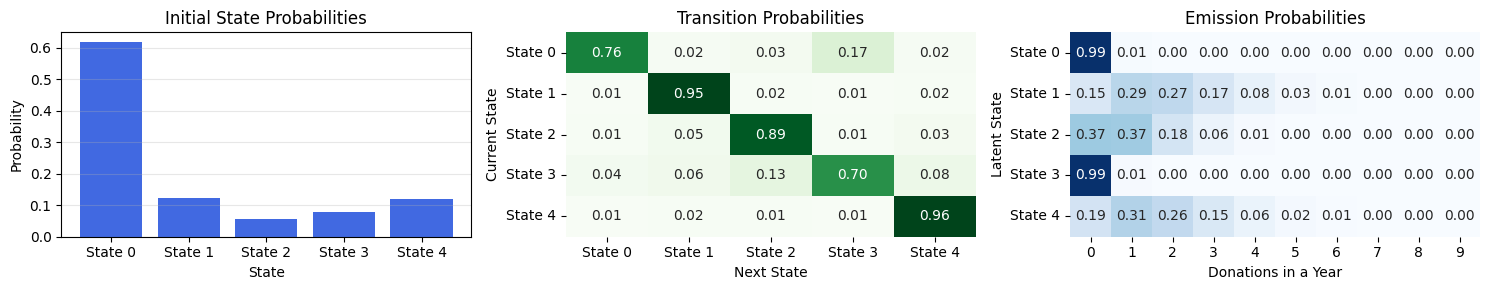

C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2432859212.py:46: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  pmf = (np.exp(-lam) * lam ** x_vals) / np.array([np.math.factorial(k) for k in x_vals])


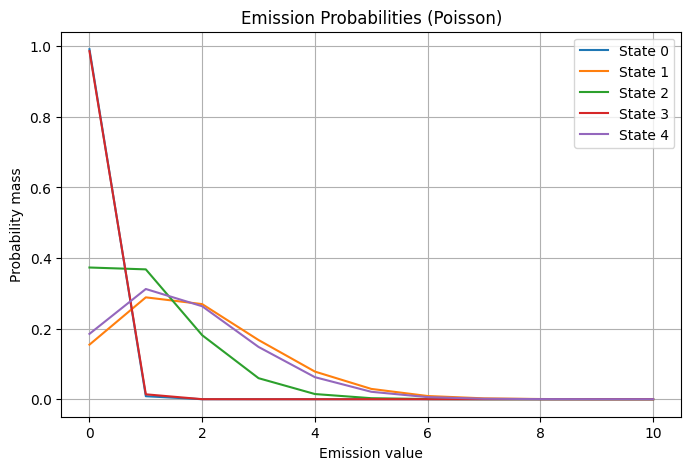


Best models for algorithm 'elbo':
elbo(2): elbo = -140374.6250
elbo(3): elbo = -139162.7031
elbo(4): elbo = -133568.0781
elbo(5): elbo = -135693.2188
elbo(6): elbo = -132776.8125 * <- Best Model

Best model for elbo with K=6, elbo = -132776.8125


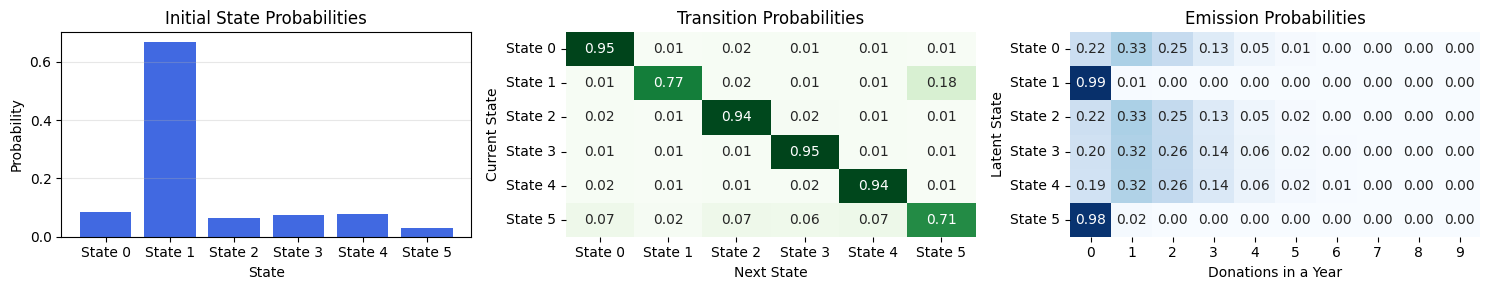

C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2432859212.py:46: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  pmf = (np.exp(-lam) * lam ** x_vals) / np.array([np.math.factorial(k) for k in x_vals])


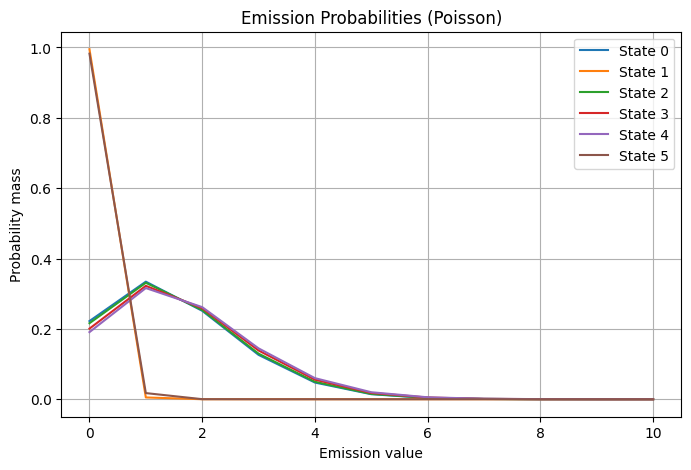

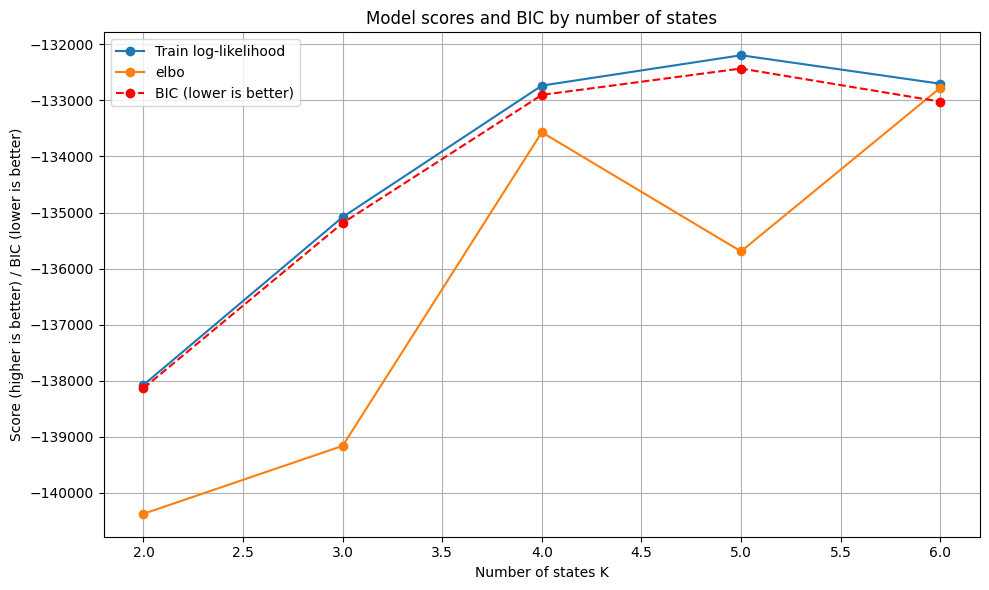

In [84]:
print_best_models_2(best_models, best_scores)
plot_all_scores_and_bic(best_scores, best_models, obs_torch)

In [ ]:
# # ------------------------------------------------------------
# def heldout_ll(params, test):
#     """log p(test | variational means) via forward algorithm"""
#     with torch.no_grad():
#         K = params["pi_alpha"].numel()
#         pi  = dist.Dirichlet(params["pi_alpha"]).mean          # [K]
#         A   = dist.Dirichlet(params["A_alpha"]).mean           # [K,K]
#         lam = params["r_alpha"] / params["r_beta"]             # [K]

#         log_pi = (pi / pi.sum()).log()
#         log_A  = (A  / A.sum(1, keepdim=True)).log()
#         emis   = dist.Poisson(lam).log_prob(test.unsqueeze(-1))  # (N,T,K)

#         N,T = test.shape
#         log_alpha = log_pi + emis[:, 0]
#         for t in range(1, T):
#             log_alpha = (log_alpha.unsqueeze(2) + log_A).logsumexp(1) + emis[:, t]
#         return log_alpha.logsumexp(1).sum().item()

# # ------------------------------------------------------------
# kf = KFold(5, shuffle=True, random_state=0)
# results = {}

# for K in range(2, 7):                       # niente K=1: poco informativo e instabile
#     elbo_list = []
#     ll_list = []
    
#     for tr_idx, te_idx in kf.split(obs_torch):
        
#         elbo, pars = fit_hmm(K, obs_torch[tr_idx])
#         held = heldout_ll(pars, obs_torch[te_idx])
        
#         elbo_list.append(elbo)
#         ll_list.append(held)
    
#     results[K] = dict(elbo=np.mean(elbo_list),
#                       heldout=np.mean(ll_list))

#     print(f"K={K} |  ELBO {results[K]['elbo']:.1f}   "
#           f"held-out LL {results[K]['heldout']:.1f}")

## Visual comparison ─ choose K via “elbow”

In [12]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # results = {K:{"elbo": … , "heldout": …}, …}  ← già calcolato sopra
# df = pd.DataFrame(results).T.sort_index()          # rows = K
# display(df)

# # ── 1. Plot ELBO and held-out log-likelihood ─────────────────────────────
# fig, ax = plt.subplots(figsize=(6,4))
# ax.plot(df.index, df["elbo"],    "o-", label="ELBO (↑)")
# ax.plot(df.index, df["heldout"], "s-", label="held-out LL (↑)")
# ax.set_xlabel("number of hidden states  K")
# ax.set_ylabel("score  (higher is better)")
# ax.set_title("Model comparison vs K")
# ax.grid(True, ls=":")
# ax.legend()
# plt.tight_layout()
# plt.show()

# # ── 2. Find “elbow” automatically (simple ∆-gain rule) ───────────────────
# def detect_elbow(series, min_gain=100.0):
#     """Return smallest K where incremental gain < min_gain."""
#     diffs = series.diff().iloc[1:]        # Δscore(K) = score(K)–score(K-1)
#     mask  = diffs.abs() < min_gain
#     return mask.idxmax() if mask.any() else series.index[-1]

# best_K = detect_elbow(df["heldout"], min_gain=100.)   # tweak threshold!
# print(f"▶ Suggested K (elbow rule) = {best_K}")

# # ── 3. Highlight choice on the plot ──────────────────────────────────────
# ax = plt.gca()
# ax.plot(best_K, df.loc[best_K, "heldout"], "ro", ms=10)
# plt.show()

## PARAMETRI CON EM 

In [88]:
import numpy as np
from scipy.special import logsumexp

def forward(obs, pi, A, lam):
    T = len(obs)
    K = len(pi)
    log_alpha = np.zeros((T, K))
    
    # log emission probabilities for t=0
    log_emis = obs[0] * np.log(lam) - lam - np.log(np.math.factorial(obs[0]))
    log_alpha[0] = np.log(pi) + log_emis

    for t in range(1, T):
        log_emis = obs[t] * np.log(lam) - lam - np.log(np.array([np.math.factorial(obs[t])] * K))
        for j in range(K):
            log_alpha[t, j] = log_emis[j] + logsumexp(log_alpha[t-1] + np.log(A[:, j]))
    return log_alpha

def backward(obs, A, lam):
    T = len(obs)
    K = A.shape[0]
    log_beta = np.zeros((T, K))
    # Initialization log_beta[T-1] = 0 (log(1))
    
    for t in reversed(range(T-1)):
        log_emis = obs[t+1] * np.log(lam) - lam - np.log(np.array([np.math.factorial(obs[t+1])] * K))
        for i in range(K):
            log_beta[t, i] = logsumexp(np.log(A[i, :]) + log_emis + log_beta[t+1])
    return log_beta

def em_hmm_poisson(obs, K, n_iter=100, tol=1e-4):
    T = len(obs)

    # Initialize parameters randomly (or uniform)
    pi = np.full(K, 1/K)
    A = np.full((K, K), 1/K)
    lam = np.random.uniform(0.5, 5, size=K)

    prev_loglik = -np.inf

    for iteration in range(n_iter):
        # E-step: compute forward and backward log probs
        log_alpha = forward(obs, pi, A, lam)
        log_beta = backward(obs, A, lam)

        # Compute log likelihood
        loglik = logsumexp(log_alpha[-1])
        if np.abs(loglik - prev_loglik) < tol:
            print(f"Converged at iteration {iteration}")
            break
        prev_loglik = loglik

        # Compute gamma and xi
        gamma = np.exp(log_alpha + log_beta - loglik)  # shape (T, K)
        xi = np.zeros((T-1, K, K))
        for t in range(T-1):
            log_emis = obs[t+1] * np.log(lam) - lam - np.log(np.array([np.math.factorial(obs[t+1])] * K))
            for i in range(K):
                for j in range(K):
                    xi[t, i, j] = log_alpha[t, i] + np.log(A[i, j]) + log_emis[j] + log_beta[t+1, j]
            xi[t] = np.exp(xi[t] - loglik)

        # M-step: update parameters
        pi = gamma[0] / gamma[0].sum()
        A = xi.sum(axis=0) / xi.sum(axis=(0, 2), keepdims=True).T

        # Update Poisson lambda
        lam = (gamma * obs[:, None]).sum(axis=0) / gamma.sum(axis=0)

    return pi, A, lam, loglik

In [91]:
# obs_torch[0,:]
obs = np.array([3, 2, 4, 3, 2, 1, 0, 2, 3, 2])  # esempio di osservazioni

em_hmm_poisson(obs, K=3, n_iter=100, tol=1e-4)

C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\3131428547.py:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  log_emis = obs[0] * np.log(lam) - lam - np.log(np.math.factorial(obs[0]))
C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\3131428547.py:14: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  log_emis = obs[t] * np.log(lam) - lam - np.log(np.array([np.math.factorial(obs[t])] * K))
C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\3131428547.py:26: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  log_emis = obs[t+1] * np.log(lam) - lam - np.log(np.array([np.math.factorial(obs[t+1])] * K))
C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\3131428547.py:

ValueError: setting an array element with a sequence.

In [ ]:
import numpy as np
from scipy.special import logsumexp
from math import factorial

def forward(obs, pi, A, lam):
    T = len(obs)
    K = len(pi)
    log_alpha = np.zeros((T, K))
    
    # Emission log-probability
    def log_emission(o, lam_k):
        return o * np.log(lam_k) - lam_k - np.log(factorial(o))
    
    # Inizializzazione
    for k in range(K):
        log_alpha[0, k] = np.log(pi[k]) + log_emission(obs[0], lam[k])
    
    # Ricorsione forward
    for t in range(1, T):
        for j in range(K):
            log_alpha[t, j] = log_emission(obs[t], lam[j]) + logsumexp(log_alpha[t-1] + np.log(A[:, j]))
    
    # Calcolo di p(X) = somma su tutti gli stati di alpha_T
    log_p_X = logsumexp(log_alpha[-1])
    
    return log_alpha, log_p_X

def backward(obs, A, lam):
    T = len(obs)
    K = len(A)
    log_beta = np.zeros((T, K))
    
    def log_emission(o, lam_k):
        return o * np.log(lam_k) - lam_k - np.log(factorial(o))
    
    # Inizializzazione
    log_beta[T-1] = 0  # log(1)
    
    # Ricorsione backward
    for t in reversed(range(T-1)):
        for i in range(K):
            log_beta[t, i] = logsumexp(np.log(A[i, :]) + 
                                       [log_emission(obs[t+1], lam[j]) for j in range(K)] + 
                                       log_beta[t+1])
    return log_beta

def compute_gamma_psi(obs, pi, A, lam):
    T = len(obs)
    K = len(pi)
    
    log_alpha = forward(obs, pi, A, lam)
    log_beta = backward(obs, A, lam)
    
    log_pX = logsumexp(log_alpha[T-1])
    
    # Calcolo gamma (T x K)
    log_gamma = log_alpha + log_beta - log_pX
    gamma = np.exp(log_gamma)
    
    # Calcolo psi (T-1 x K x K)
    psi = np.zeros((T-1, K, K))
    for t in range(1, T):
        for i in range(K):
            for j in range(K):
                # log psi numerator
                log_num = (log_alpha[t-1, i] + np.log(A[i, j]) + 
                           obs[t] * np.log(lam[j]) - lam[j] - np.log(factorial(obs[t])) +
                           log_beta[t, j])
                psi[t-1, i, j] = np.exp(log_num - log_pX)
    
    return gamma, psi

def update_parameters_from_gamma_psi(gamma, psi):

    """
    Aggiorna pi e A a partire da gamma e psi.
    
    gamma: array (T, K) delle probabilità posteriori per ogni stato e tempo
    psi: array (T-1, K, K) delle probabilità congiunte di transizione
    
    Ritorna:
        pi_new: array (K,) nuova distribuzione iniziale
        A_new: array (K, K) nuova matrice di transizione
    """
    T, K = gamma.shape
    
    # Aggiorna pi: distribuzione iniziale
    pi_new = gamma[0] / gamma[0].sum()
    
    # Aggiorna A: matrice di transizione
    # Numeratore: somma su n di psi[n, j, k]
    numerator = psi.sum(axis=0)  # shape (K, K)
    
    # Denominatore: somma su n e k' di psi[n, j, k']
    denominator = numerator.sum(axis=1, keepdims=True)  # shape (K, 1)
    
    A_new = numerator / denominator  # normalizza ogni riga
    
    return pi_new, A_new

In [108]:
import numpy as np
from scipy.special import logsumexp, factorial

def hmm_em(obs, K, max_iter=100, tol=1e-4, verbose=False):
    T = len(obs)
    
    # Inizializzazione casuale dei parametri
    pi = np.random.dirichlet(np.ones(K))
    A = np.random.dirichlet(np.ones(K), size=K)
    lam = np.random.rand(K) * (np.mean(obs) + 1)

    log_likelihoods = []

    def log_emission(o, lam_k):
        return o * np.log(lam_k) - lam_k - np.log(factorial(o))
    
    for iteration in range(max_iter):
        # Forward
        log_alpha = np.zeros((T, K))
        for k in range(K):
            log_alpha[0, k] = np.log(pi[k]) + log_emission(obs[0], lam[k])
        for t in range(1, T):
            for j in range(K):
                log_alpha[t, j] = log_emission(obs[t], lam[j]) + logsumexp(log_alpha[t-1] + np.log(A[:, j]))
        log_pX = logsumexp(log_alpha[-1])
        log_likelihoods.append(log_pX)

        # Backward
        log_beta = np.zeros((T, K))
        log_beta[T-1] = 0
        for t in reversed(range(T-1)):
            for i in range(K):
                emis = np.array([log_emission(obs[t+1], lam[j]) for j in range(K)])
                log_beta[t, i] = logsumexp(np.log(A[i, :]) + emis + log_beta[t+1])

        # Gamma
        log_gamma = log_alpha + log_beta - log_pX
        gamma = np.exp(log_gamma)

        # Psi
        psi = np.zeros((T-1, K, K))
        for t in range(1, T):
            for i in range(K):
                for j in range(K):
                    log_num = (
                        log_alpha[t-1, i]
                        + np.log(A[i, j])
                        + log_emission(obs[t], lam[j])
                        + log_beta[t, j]
                    )
                    psi[t-1, i, j] = np.exp(log_num - log_pX)

        # M-step: aggiorna i parametri
        pi = gamma[0] / gamma[0].sum()
        A = psi.sum(axis=0)
        A /= A.sum(axis=1, keepdims=True)

        lam = (gamma * obs[:, None]).sum(axis=0) / gamma.sum(axis=0)

        # Controllo di convergenza
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            if verbose:
                print(f"Converged at iteration {iteration}")
            break

    return {
        "pi": pi,
        "A": A,
        "lam": lam,
        "log_likelihoods": log_likelihoods
    }


obs = obs_torch[0,:].numpy()  # Converti in numpy array per l'EM
result = hmm_em(obs, K=3, max_iter=100, tol=1e-4, verbose=True)

print("pi:", result["pi"])
print("A:", result["A"])
print("lam:", result["lam"])
print("log p(X):", result["log_likelihoods"][-1])

Converged at iteration 37
pi: [2.85110163e-017 1.00000000e+000 7.42721332e-180]
A: [[8.11171569e-01 2.41032971e-05 1.88804327e-01]
 [1.88140885e-01 8.11859053e-01 6.20922113e-08]
 [5.24911893e-34 2.62409728e-42 1.00000000e+00]]
lam: [1.31303130e-010 3.47767350e-109 1.36746827e+000]
log p(X): -7.968590617378577


In [ ]:
# Assumiamo che obs_torch abbia shape (N, T)
N = obs_torch.shape[0]
K = 3  # Numero di stati nascosti

pi_list = []
A_list = []
lam_list = []
p_X_list = []

for i in range(N):
    print(f"Fitting HMM for sequence {i}")
    obs = obs_torch[i].numpy()
    result = hmm_em(obs, K=K, max_iter=100, tol=1e-4, verbose=False)
    
    pi_list.append(result["pi"])
    A_list.append(result["A"])
    lam_list.append(result["lam"])
    p_X_list.append(result["log_likelihoods"][-1])


# # Converti in numpy array per calcolare la media
# pi_array = np.stack(pi_list)       # shape (N, K)
# A_array = np.stack(A_list)         # shape (N, K, K)
# lam_array = np.stack(lam_list)     # shape (N, K)

# # Calcola media su tutte le catene
# pi_mean = pi_array.mean(axis=0)        # shape (K,)
# A_mean = A_array.mean(axis=0)          # shape (K, K)
# lam_mean = lam_array.mean(axis=0)      # shape (K,)

# # Stampa o restituisci i risultati
# print("Media su tutte le catene:")
# print("pi media:", pi_mean)
# print("A media:\n", A_mean)
# print("lam media:", lam_mean)

Fitting HMM for sequence 0


C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2192432828.py:21: RuntimeWarning: divide by zero encountered in log
  log_alpha[0, k] = np.log(pi[k]) + log_emission(obs[0], lam[k])
C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2192432828.py:15: RuntimeWarning: divide by zero encountered in log
  return o * np.log(lam_k) - lam_k - np.log(factorial(o))
C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2192432828.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  return o * np.log(lam_k) - lam_k - np.log(factorial(o))


Fitting HMM for sequence 1
Fitting HMM for sequence 2
Fitting HMM for sequence 3
Fitting HMM for sequence 4
Fitting HMM for sequence 5
Fitting HMM for sequence 6
Fitting HMM for sequence 7


C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2192432828.py:24: RuntimeWarning: divide by zero encountered in log
  log_alpha[t, j] = log_emission(obs[t], lam[j]) + logsumexp(log_alpha[t-1] + np.log(A[:, j]))
C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2192432828.py:34: RuntimeWarning: divide by zero encountered in log
  log_beta[t, i] = logsumexp(np.log(A[i, :]) + emis + log_beta[t+1])
C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2192432828.py:47: RuntimeWarning: divide by zero encountered in log
  + np.log(A[i, j])


Fitting HMM for sequence 8
Fitting HMM for sequence 9
Fitting HMM for sequence 10
Fitting HMM for sequence 11
Fitting HMM for sequence 12
Fitting HMM for sequence 13
Fitting HMM for sequence 14
Fitting HMM for sequence 15
Fitting HMM for sequence 16
Fitting HMM for sequence 17
Fitting HMM for sequence 18
Fitting HMM for sequence 19
Fitting HMM for sequence 20
Fitting HMM for sequence 21
Fitting HMM for sequence 22
Fitting HMM for sequence 23
Fitting HMM for sequence 24
Fitting HMM for sequence 25
Fitting HMM for sequence 26
Fitting HMM for sequence 27
Fitting HMM for sequence 28
Fitting HMM for sequence 29
Fitting HMM for sequence 30
Fitting HMM for sequence 31
Fitting HMM for sequence 32
Fitting HMM for sequence 33
Fitting HMM for sequence 34
Fitting HMM for sequence 35
Fitting HMM for sequence 36
Fitting HMM for sequence 37
Fitting HMM for sequence 38
Fitting HMM for sequence 39
Fitting HMM for sequence 40
Fitting HMM for sequence 41
Fitting HMM for sequence 42
Fitting HMM for sequen

C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2192432828.py:56: RuntimeWarning: invalid value encountered in divide
  A /= A.sum(axis=1, keepdims=True)


Fitting HMM for sequence 811
Fitting HMM for sequence 812
Fitting HMM for sequence 813
Fitting HMM for sequence 814
Fitting HMM for sequence 815
Fitting HMM for sequence 816
Fitting HMM for sequence 817
Fitting HMM for sequence 818
Fitting HMM for sequence 819
Fitting HMM for sequence 820
Fitting HMM for sequence 821
Fitting HMM for sequence 822
Fitting HMM for sequence 823
Fitting HMM for sequence 824
Fitting HMM for sequence 825
Fitting HMM for sequence 826
Fitting HMM for sequence 827
Fitting HMM for sequence 828
Fitting HMM for sequence 829
Fitting HMM for sequence 830
Fitting HMM for sequence 831
Fitting HMM for sequence 832
Fitting HMM for sequence 833
Fitting HMM for sequence 834
Fitting HMM for sequence 835
Fitting HMM for sequence 836
Fitting HMM for sequence 837
Fitting HMM for sequence 838
Fitting HMM for sequence 839
Fitting HMM for sequence 840
Fitting HMM for sequence 841
Fitting HMM for sequence 842
Fitting HMM for sequence 843
Fitting HMM for sequence 844
Fitting HMM fo

In [ ]:
# Esempio di uso:
obs = np.array([3, 2, 4, 3, 2, 1])  # osservazioni
K = 2  # numero di stati
pi = np.array([0.6, 0.4])  # probabilità iniziali
A = np.array([[0.7, 0.3],
              [0.4, 0.6]])
lam = np.array([2.0, 5.0])  # parametri Poisson per ogni stato

gamma, psi = compute_gamma_psi(obs, pi, A, lam)

print("Gamma (probabilità posteriori stati per ogni t):")
print(gamma)
print("\nPsi (probabilità congiunte transizioni):")
print(psi)

Gamma (probabilità posteriori stati per ogni t):
[[0.71659384 0.28340616]
 [0.80465119 0.19534881]
 [0.5307926  0.4692074 ]
 [0.6930573  0.3069427 ]
 [0.87428285 0.12571715]
 [0.93594583 0.06405417]]

Psi (probabilità congiunte transizioni):
[[[0.62070444 0.09588939]
  [0.18394675 0.09945941]]

 [[0.47402502 0.33062617]
  [0.05676758 0.13858123]]

 [[0.43218219 0.09861041]
  [0.26087511 0.20833229]]

 [[0.63826096 0.05479634]
  [0.2360219  0.0709208 ]]

 [[0.83000752 0.04427533]
  [0.1059383  0.01977884]]]


In [103]:
pi_new, A_new = update_parameters_from_gamma_psi(gamma, psi)

print("Nuova pi iniziale:")
print(pi_new)

print("Nuova matrice di transizione A:")
print(A_new)
gamma

Nuova pi iniziale:
[0.71659384 0.28340616]
Nuova matrice di transizione A:
[[0.82754007 0.17245993]
 [0.61099237 0.38900763]]


array([[0.71659384, 0.28340616],
       [0.80465119, 0.19534881],
       [0.5307926 , 0.4692074 ],
       [0.6930573 , 0.3069427 ],
       [0.87428285, 0.12571715],
       [0.93594583, 0.06405417]])